Processing Tropical Vegetation: urbanVegetationClimate_1990_2020_tropical.csv
Processing Tropical Trees: urbanTreeCover_1992_2020_tropical.csv
Processing Arid Vegetation: urbanVegetationClimate_1992_2020_arid.csv
Processing Arid Trees: urbanTreeCover_1992_2020_arid.csv
Processing Temperate Vegetation: urbanVegetationClimate_1990_2020_temperateV2_100m.csv
Processing Temperate Trees: urbanTreeCover_1992_2020_temperate.csv
Processing Continental Vegetation: urbanVegetationClimate_1990_2020_continental.csv


/tmp/ipython-input-2560288938.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_weighted_avg, frac_col='frac', weight_col='weight')
/tmp/ipython-input-2560288938.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_weighted_avg, frac_col='frac', weight_col='weight')
/tmp/ipython-input-2560288938.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This be

Processing Continental Trees: urbanTreeCover_1992_2020_continental.csv


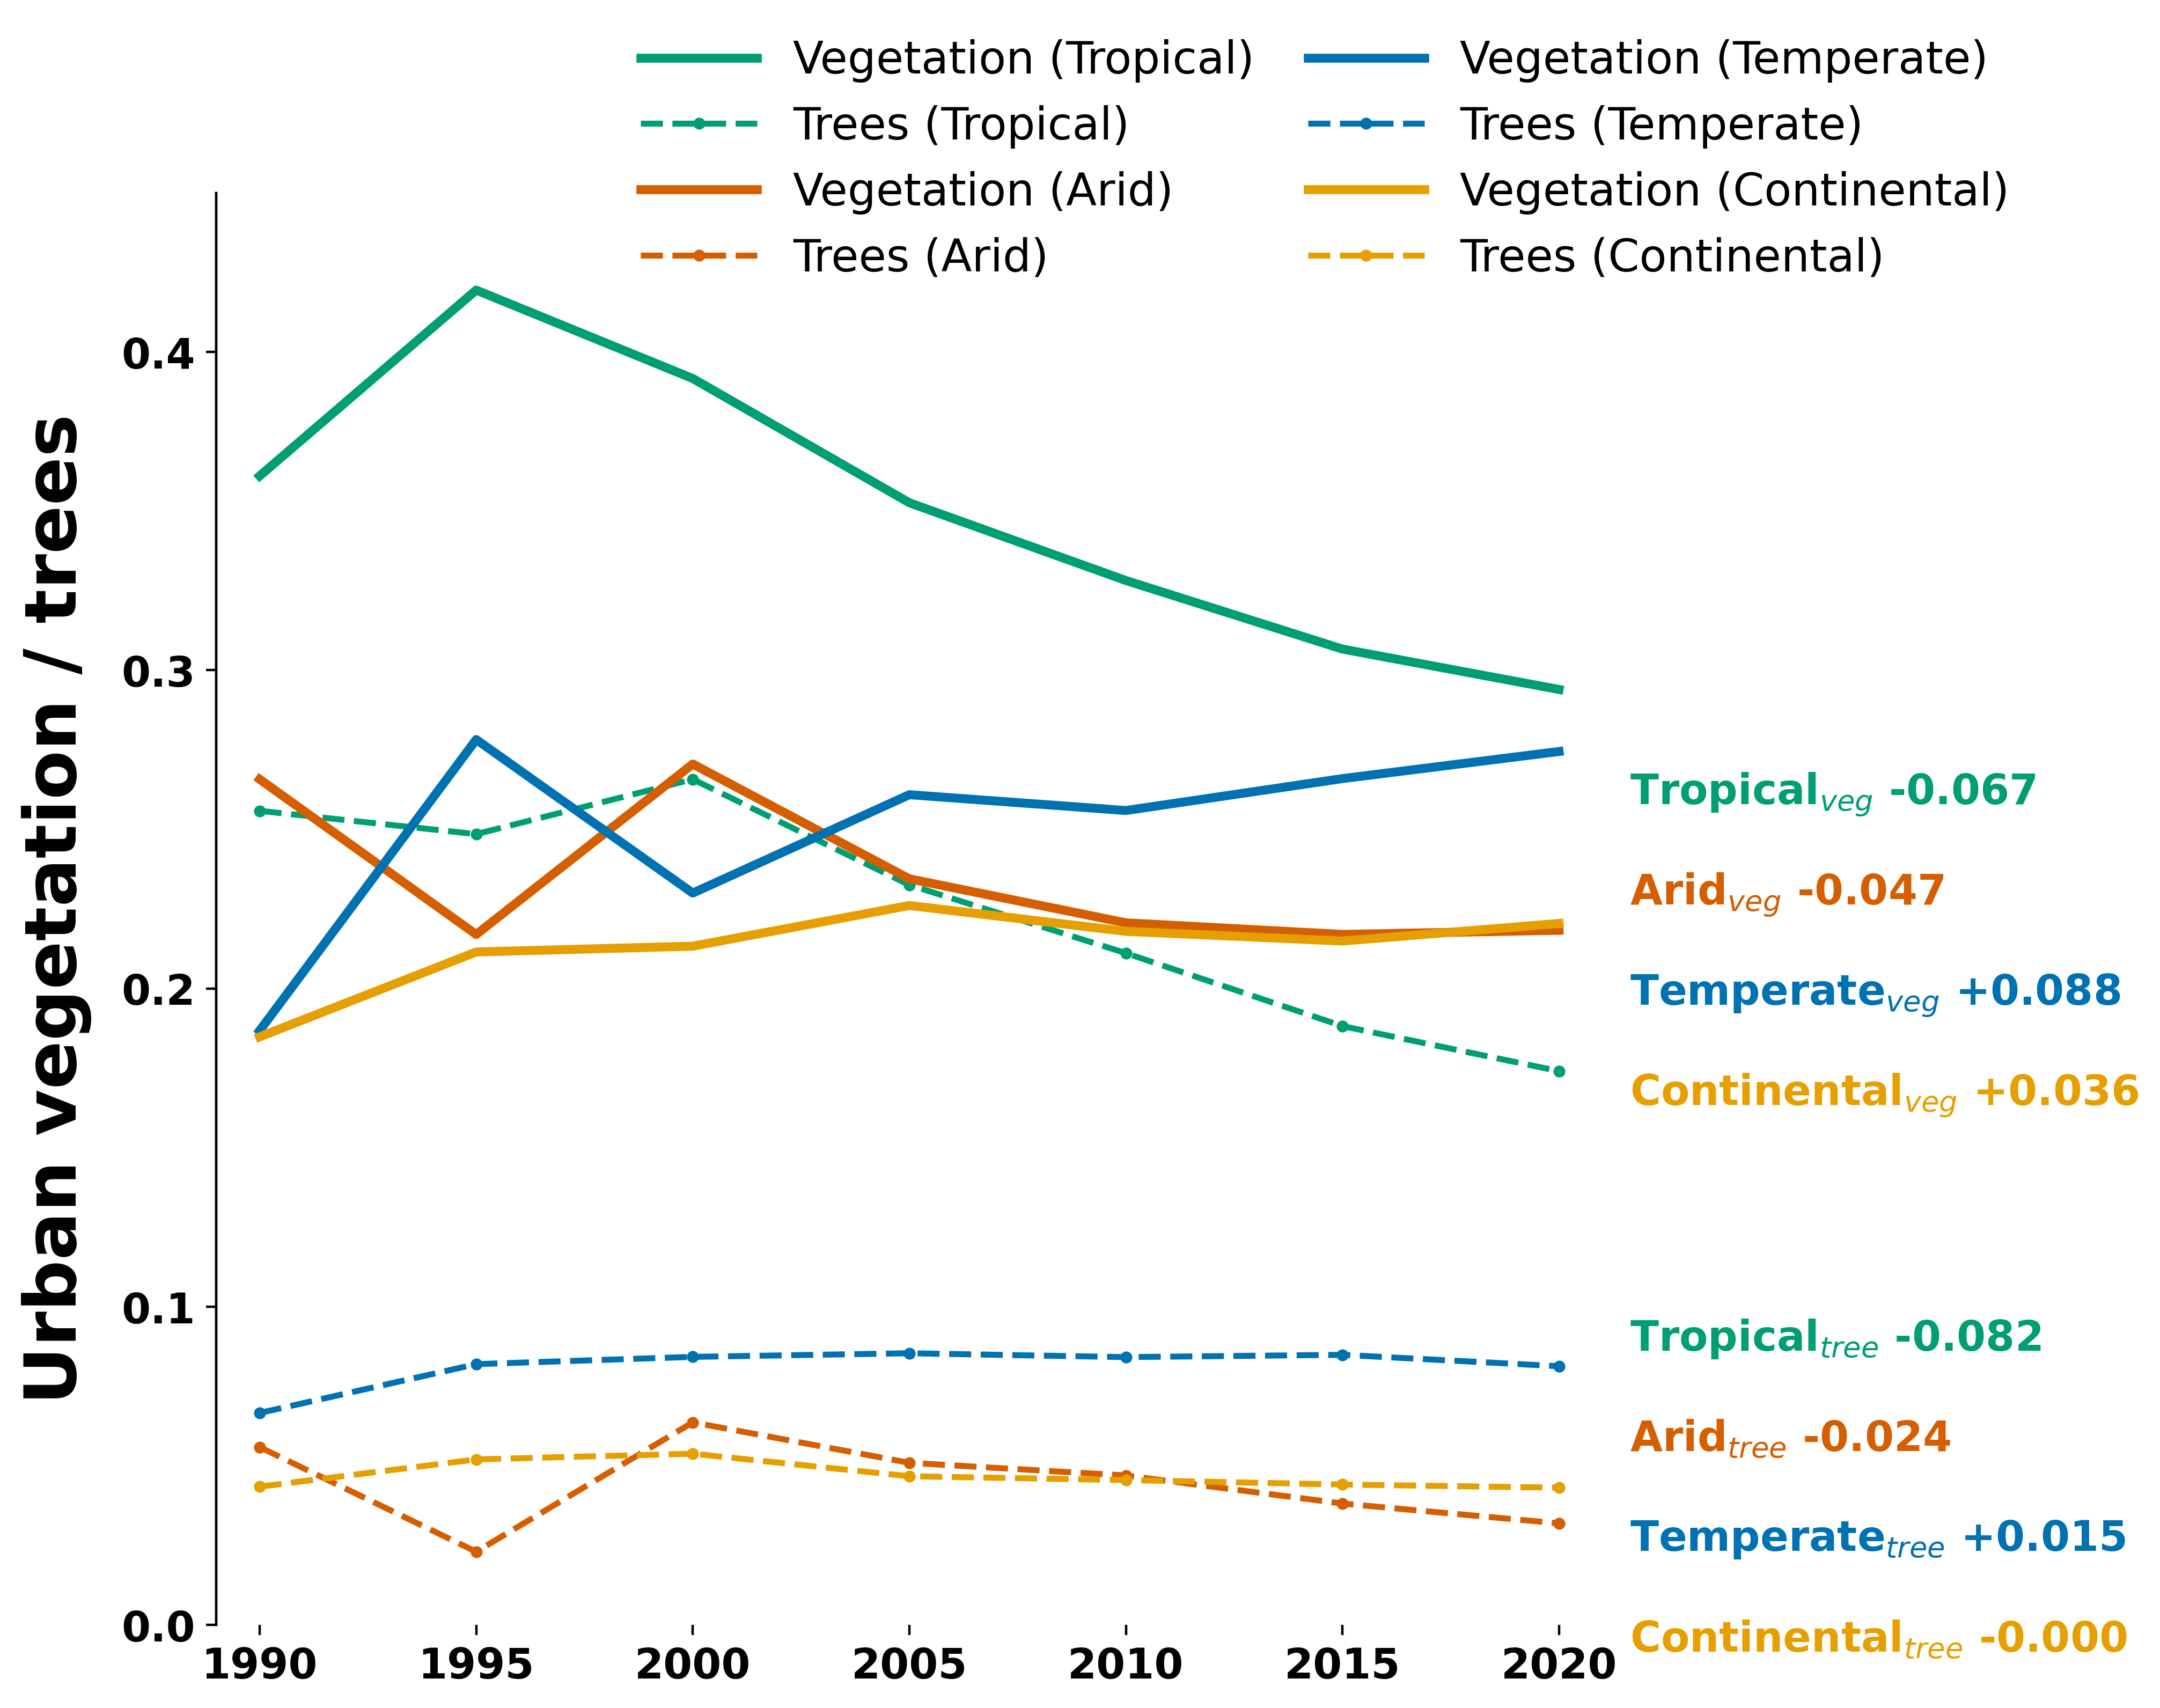

Saved figure to: /content/drive/MyDrive/UrbanVegetation/FiguresV2/Fig5C.pdf

Increase (2020 − 1990) in fraction units (positive = increase):
Tropical     Vegetation:  -0.0671   Trees:  -0.0818
Arid         Vegetation:  -0.0475   Trees:  -0.0240
Temperate    Vegetation:   0.0877   Trees:   0.0147
Continental  Vegetation:   0.0356   Trees:  -0.0003
Tropical      VEG:  urbanVegetationClimate_1990_2020_tropical.csv
              TREE: urbanTreeCover_1992_2020_tropical.csv
Arid          VEG:  urbanVegetationClimate_1992_2020_arid.csv
              TREE: urbanTreeCover_1992_2020_arid.csv
Temperate     VEG:  urbanVegetationClimate_1990_2020_temperateV2_100m.csv
              TREE: urbanTreeCover_1992_2020_temperate.csv
Continental   VEG:  urbanVegetationClimate_1990_2020_continental.csv
              TREE: urbanTreeCover_1992_2020_continental.csv


In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

# ─────────────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────────────
FOLDER = "/content/"
OUTPUT = os.path.join(FOLDER, "FiguresV2/Fig5C.pdf")

CLIMATES = ["Tropical", "Arid", "Temperate", "Continental"]

# Okabe–Ito
COLORS = {
    "Tropical":    "#009E73",  # bluish green
    "Arid":        "#D55E00",  # vermilion
    "Temperate":   "#0072B2",  # blue
    "Continental": "#E69F00",  # orange
}

TREE_HINTS = ["tree", "urbantreecover"]
VEG_HINTS  = ["vegetation", "veg"]

YEAR_CANDS      = ["year"]
TREE_PCT_CANDS  = ["tree_pct","trees_pct","treecover_pct","tree_cover_pct","tree_percent","treecover_percent",
                   "tree_cover_percent","tree_perc","treepc"]
VEG_PCT_CANDS   = ["veg_pct","vegetation_pct","veg_percent","vegetation_percent","veg_perc","vegpc","vegetationpc"]
BUILT_KM2_CANDS = ["built_km2","urban_built_km2","builtup_km2"]
TREE_KM2_CANDS  = ["urbanTree_km2","tree_km2","trees_km2"]
VEG_KM2_CANDS   = ["urbanVeg_km2","vegetation_km2","veg_km2","urbanVegetation_km2"]

# Plot in FRACTIONS (0–1)
LEFT_Y_LIM = (0.0, 0.45)

# ───────── STACKED LABELS (right side) ─────────
STACK_X = 1.02       # x position in axes fraction (outside right)
START_Y = 0.58       # top y position (axes fraction)
LINE_H  = 0.07       # vertical step
GROUP_GAP = 0.10     # gap between veg and tree blocks
LABEL_FONTSIZE = 14

# ─────────────────────────────────────────────────────────────────────────────
# HELPERS
# ─────────────────────────────────────────────────────────────────────────────
def _first_col(cols, cands):
    m = {c.lower(): c for c in cols}
    for c in cands:
        if c.lower() in m:
            return m[c.lower()]
    return None

def _derive_frac(df, class_km2_cands, built_km2_cands):
    ck = _first_col(df.columns, class_km2_cands)
    bk = _first_col(df.columns, built_km2_cands)
    if ck and bk:
        with np.errstate(divide="ignore", invalid="ignore"):
            num = pd.to_numeric(df[ck], errors="coerce")
            den = pd.to_numeric(df[bk], errors="coerce")
            frac = num / den
        return frac
    return None

def _as_fraction(series):
    s = pd.to_numeric(series, errors="coerce")
    if s.dropna().empty:
        return s
    # Check if max > 1.0 (with a small tolerance)
    if s.max(skipna=True) > 1.0 + 1e-9:
        return s / 100.0
    return s

def _weighted_avg(grp, frac_col='frac', weight_col='weight'):
    """Calculate the weighted average for a group."""
    frac = grp[frac_col]
    w = grp[weight_col]

    # Filter out NaNs or zero/negative weights
    mask = pd.notna(frac) & pd.notna(w) & (w > 0)
    frac, w = frac[mask], w[mask]

    if w.sum() == 0:
        return np.nan

    return (frac * w).sum() / w.sum()

def _remap_1992_to_1990_and_collapse(df, label, path):
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    if df["year"].isna().all():
        raise ValueError(f"All 'year' values are NaN in {path}")
    if (df["year"] == 1992).any():
        df.loc[df["year"] == 1992, "year"] = 1990

    if df.duplicated(subset="year").any():
        print(f"[INFO] Collapsed duplicate years for {label}: {os.path.basename(path)} (WEIGHTED mean fraction).")

    out = (df.groupby("year")
             .apply(_weighted_avg, frac_col='frac', weight_col='weight')
             .to_frame(name='frac') # Convert Series back to DataFrame
             .reset_index()         # Make 'year' a column again
             .sort_values("year"))

    return out

def read_metric_df(path, kind):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    try:
        df = pd.read_csv(path)
    except Exception as e:
        raise RuntimeError(f"Failed reading CSV {path}: {e}")

    ycol = _first_col(df.columns, YEAR_CANDS)
    if not ycol:
        raise ValueError(f"No 'year' column in {path}. Columns: {list(df.columns)}")

    wcol = _first_col(df.columns, BUILT_KM2_CANDS)
    if not wcol:
        raise ValueError(f"No built-up area (weight) column found in {path} using candidates {BUILT_KM2_CANDS}")

    df['weight'] = pd.to_numeric(df[wcol], errors='coerce')
    # -----------------------------------------------------

    if kind == "trees":
        pcol = _first_col(df.columns, TREE_PCT_CANDS)
        frac = _as_fraction(df[pcol]) if pcol else _derive_frac(df, TREE_KM2_CANDS, BUILT_KM2_CANDS)
    else:
        pcol = _first_col(df.columns, VEG_PCT_CANDS)
        frac = _as_fraction(df[pcol]) if pcol else _derive_frac(df, VEG_KM2_CANDS, BUILT_KM2_CANDS)

    if frac is None:
        raise ValueError(f"Could not find or derive fraction for {kind} in {path}")

    # Create the dataframe with year, frac, and weight
    out = pd.DataFrame({
        "year": pd.to_numeric(df[ycol], errors="coerce"),
        "frac": frac,
        "weight": df['weight'] # Pass weight to the next step
    }).dropna(subset=['year', 'frac', 'weight'])

    if out.empty:
        raise ValueError(f"No valid rows (with year, frac, and weight) after parsing {path}")

    return _remap_1992_to_1990_and_collapse(out, kind, path)

def _match_file(folder, zone, hints):
    zone_l = zone.lower()
    files = glob.glob(os.path.join(folder, "*.csv"))
    strong = [f for f in files if zone_l in os.path.basename(f).lower()
              and all(h.lower() in os.path.basename(f).lower() for h in hints)]
    if strong:
        return sorted(strong)[0]
    relaxed = [f for f in files if zone_l in os.path.basename(f).lower()
               and any(h.lower() in os.path.basename(f).lower() for h in hints)]
    return sorted(relaxed)[0] if relaxed else None

def collect_inputs(folder):
    mapping, missing = {}, []
    for z in CLIMATES:
        veg = _match_file(folder, z, VEG_HINTS)
        tre = _match_file(folder, z, TREE_HINTS)
        mapping[z] = {"veg": veg, "tree": tre}
        if veg is None: missing.append(f"Vegetation CSV for {z}")
        if tre is None: missing.append(f"Tree CSV for {z}")
    return mapping, missing

def increase_fraction(df):
    """Absolute increase (fraction units): f_2020 − f_1990."""
    if df.empty:
        return np.nan
    s = df.set_index("year")["frac"]
    if 1990 not in s.index or 2020 not in s.index:
        return np.nan
    f0, f1 = s.loc[1990], s.loc[2020]
    if pd.isna(f0) or pd.isna(f1):
        return np.nan
    return f1 - f0

# ─────────────────────────────────────────────────────────────────────────────
# I/O CHECK
# ─────────────────────────────────────────────────────────────────────────────
if not os.path.isdir(FOLDER):
    raise SystemExit(f"Folder not found: {FOLDER}. Did you mount Google Drive?")

mapping, missing = collect_inputs(FOLDER)
if missing:
    raise SystemExit("Missing inputs:\n  - " + "\n  - ".join(missing) + f"\n\nCheck files in {FOLDER}")

# ─────────────────────────────────────────────────────────────────────────────
# READ + PLOT
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=400)
ax = plt.gca()

ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()

# REMOVE GRID LINES
for spine in ("top", "bottom", "right"):
    ax.spines[spine].set_visible(False)

for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')
    lbl.set_fontsize(14)

ax.tick_params(axis="y", right=False, left=True)
ax.minorticks_off()

all_years = set()
changes = []  # (zone, kind, increase, color, linestyle)

for zone in CLIMATES:
    color = COLORS[zone]

    print(f"Processing {zone} Vegetation: {os.path.basename(mapping[zone]['veg'])}")
    veg_df  = read_metric_df(mapping[zone]["veg"],  "vegetation")

    print(f"Processing {zone} Trees: {os.path.basename(mapping[zone]['tree'])}")
    tree_df = read_metric_df(mapping[zone]["tree"], "trees")

    all_years.update(veg_df["year"].astype(int).tolist())
    all_years.update(tree_df["year"].astype(int).tolist())

    ax.plot(
        veg_df["year"].astype(int), veg_df["frac"],
        label=f"Vegetation ({zone})",
        color=color, linestyle="-", linewidth=3.0, marker=None
    )
    ax.plot(
        tree_df["year"].astype(int), tree_df["frac"],
        label=f"Trees ({zone})",
        color=color, linestyle="--", linewidth=2.0, marker="o", markersize=3
    )

    veg_inc = increase_fraction(veg_df)
    tre_inc = increase_fraction(tree_df)
    changes.append((zone, "veg",  veg_inc, color, "-"))
    changes.append((zone, "tree", tre_inc, color, "--"))

if not all_years:
    raise SystemExit("No years found in inputs. Check CSV contents.")
years = sorted(all_years)
ax.set_xticks(years)
ax.set_xlim(min(years) - 1, max(years) + 1)

# FRACTION axis
ax.set_ylim(*LEFT_Y_LIM)
ax.yaxis.set_major_locator(MultipleLocator(0.10))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.1f}"))
ax.set_ylabel("Urban vegetation / trees", fontweight="bold", fontsize=24, labelpad=10)

# Right axis (for text only)
ax_right = ax.twinx()
ax_right.set_yticks([])
for spine in ("right", "top", "bottom"):
    ax_right.spines[spine].set_visible(False)

# ─────────────────────────────────────────────────────────────────────────────
# STACKED LABELS with subscripts: Tropical_{veg}, Tropical_{tree}, ...
# ─────────────────────────────────────────────────────────────────────────────
veg_labels = [(z, k, chg, col) for (z, k, chg, col, ls) in changes if k == "veg"]
tre_labels = [(z, k, chg, col) for (z, k, chg, col, ls) in changes if k == "tree"]

def _fmt_label(zone, kind, chg):
    # kind is 'veg' or 'tree'
    sub = "veg" if kind == "veg" else "tree"
    if not np.isfinite(chg):
        return fr"{zone}$_{{{sub}}}$ NA"
    sign = "+" if chg >= 0 else ""
    return fr"{zone}$_{{{sub}}}$ {sign}{chg:.3f}"

# Vegetation block
y_cursor = START_Y
for (zone, kind, chg, col) in veg_labels:
    ax.text(
        STACK_X, y_cursor, _fmt_label(zone, kind, chg),
        transform=ax.transAxes, ha="left", va="center",
        color=col, fontsize=LABEL_FONTSIZE, fontweight="bold", clip_on=False
    )
    y_cursor -= LINE_H

# Gap
y_cursor -= GROUP_GAP

# Trees block
for (zone, kind, chg, col) in tre_labels:
    ax.text(
        STACK_X, y_cursor, _fmt_label(zone, kind, chg),
        transform=ax.transAxes, ha="left", va="center",
        color=col, fontsize=LABEL_FONTSIZE, fontweight="bold", clip_on=False
    )
    y_cursor -= LINE_H

# Legend
ax.legend(
    ncol=2, frameon=False,
    loc="upper center", bbox_to_anchor=(0.8, 1.12),
    handlelength=2.6, columnspacing=1.2, borderaxespad=0.0,
    fontsize=15,
)

# Extra right margin for labels
plt.subplots_adjust(right=0.8)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save and report
plt.savefig(OUTPUT, bbox_inches="tight")
plt.show()

print("Saved figure to:", OUTPUT)
print("\nIncrease (2020 − 1990) in fraction units (positive = increase):")
for zone in CLIMATES:
    veg = next((c for c in changes if c[0]==zone and c[1]=="veg"), None)
    tre = next((c for c in changes if c[0]==zone and c[1]=="tree"), None)
    veg_ch = "NA" if veg is None or not np.isfinite(veg[2]) else f"{veg[2]:.4f}"
    tre_ch = "NA" if tre is None or not np.isfinite(tre[2]) else f"{tre[2]:.4f}"
    print(f"{zone:12s} Vegetation: {veg_ch:>8s}   Trees: {tre_ch:>8s}")

for z in CLIMATES:
    print(f"{z:12s}  VEG:  {os.path.basename(mapping[z]['veg'])}")
    print(f"{'':12s}  TREE: {os.path.basename(mapping[z]['tree'])}")